# Rice classification

## Introduction

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.io import read_image
from torchvision import tv_tensors, models
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T

In [ ]:
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Torch version: 2.3.1+cu121
Torchvision version: 0.18.1+cu121


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH_DATA = "/content/drive/MyDrive/data/rice"

## Data

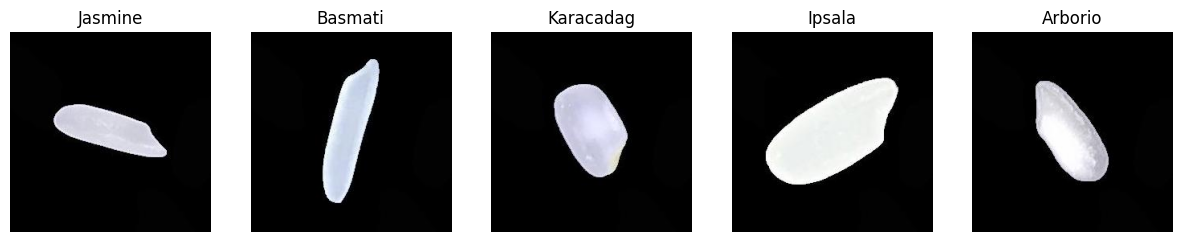

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

path_train_data = os.path.join(PATH_DATA, "train")
for i, d in enumerate(os.listdir(path_train_data)):
    image_name = os.listdir(os.path.join(path_train_data, d))[0]
    image_path = os.path.join(path_train_data, d , image_name)
    image = read_image(image_path)
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(d)
    axes[i].axis("off")

plt.show()

In [ ]:
class RiceDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        # Get list of image paths
        self.imgs = []
        self.classes = []

        classes = list(sorted(os.listdir(root)))

        for i, d in enumerate(classes):
            for i2, f in enumerate(os.listdir(os.path.join(root, d))):
              # Add classes
              self.classes.append(i)

              # Add images
              self.imgs.append(os.path.join(root, d, f))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.imgs[idx]

        # Get target
        target = self.classes[idx]

        # Read image as RGB Tensor (3 channels)
        img = read_image(img_path)#.float() / 255.0

        # Wrap sample and targets into torchvision tv_tensors in order improve transform performance
        img = tv_tensors.Image(img)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [ ]:
def get_transform(train):
    transforms = []

    transforms.append(T.Resize((224, 224)))
    transforms.append(T.ToTensor())
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

## Training

In [ ]:
def get_model_resnet18(num_classes):
    # Load pre-trained ResNet model
    model = models.resnet18(weights='IMAGENET1K_V1')

    # Modify the final layer to match the number of classes
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, num_classes)

    return model

In [ ]:
def train_one_epoch(model, optimizer, criterion, data_loader, device, epoch, print_freq = 10):
    print(f"\nEpoch: {epoch}")
    print(f"Total batch iteration: {len(data_loader)}")
    model.train()

    loss = 0
    loss_accumulated = 0
    for batch, (images, targets) in enumerate(data_loader):
        # Move images and targets to the specified device (GPU or CPU)
        images = images.to(device)
        targets = targets.to(device)

        # Forward pass: Compute predicted outputs by passing inputs to the model
        outputs = model(images)

        # Sum the losses for different components
        losses = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Print training information at the specified frequency
        loss = losses.item()
        loss_accumulated += loss

        if batch % print_freq == 0:
            print(f"Iteration {batch} - Loss: {loss}")

    print(f"Average loss for total data: {loss_accumulated / len(data_loader)}")

In [ ]:
# Train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 5

# Use our dataset and defined transformations
dataset_train = RiceDataset(os.path.join(PATH_DATA, "train"), get_transform(train=True))
dataset_test = RiceDataset(os.path.join(PATH_DATA, "test"), get_transform(train=False))

data_loader_train = torch.utils.data.DataLoader(
    dataset = dataset_train,
    batch_size = 2,
    shuffle = True
)

data_loader_test = torch.utils.data.DataLoader(
    dataset = dataset_test,
    batch_size = 1,
    shuffle = False
)

# Get the model
model = get_model_resnet18(num_classes)

# Move model to the right device
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, criterion, data_loader_train, device, epoch)

print("Done!")


Epoch: 0
Total batch iteration: 50
Iteration 0 - Loss: 1.6131186485290527
Iteration 10 - Loss: 4.104093551635742
Iteration 20 - Loss: 2.7066259384155273
Iteration 30 - Loss: 2.4341275691986084
Iteration 40 - Loss: 1.5573524236679077
Average loss for total data: 1.8289232581853867

Epoch: 1
Total batch iteration: 50
Iteration 0 - Loss: 0.8022693395614624
Iteration 10 - Loss: 1.3795738220214844
Iteration 20 - Loss: 1.883933424949646
Iteration 30 - Loss: 0.1778799593448639
Iteration 40 - Loss: 0.9478779435157776
Average loss for total data: 1.1250871893763543
Done!
